In [2]:
!pip install kaggle

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
!pip install statsmodels

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
pip install pmdarima


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.seasonal import seasonal_decompose
import pmdarima as pm

In [6]:
!kaggle datasets download -d sumanthvrao/daily-climate-time-series-data

daily-climate-time-series-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
import zipfile

In [8]:
# we have more than one csv files in the zip file and I need to load the two of them
zip_file_path = 'daily-climate-time-series-data.zip'

# Step 1: Read both CSV files directly from the ZIP archive
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    with zip_ref.open('DailyDelhiClimateTrain.csv') as train_file:
        df_train = pd.read_csv(train_file)

    with zip_ref.open('DailyDelhiClimateTest.csv') as test_file:
        df_test = pd.read_csv(test_file)

Let have a lok at the first few rows of our datasets


In [9]:
df_train.head(n=9)

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000
5,2013-01-06,7.000000,82.800000,1.480000,1018.000000
6,2013-01-07,7.000000,78.600000,6.300000,1020.000000
7,2013-01-08,8.857143,63.714286,7.142857,1018.714286
8,2013-01-09,14.000000,51.250000,12.500000,1017.000000


In [10]:
df_test.head(n=7)

,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333
5,2017-01-06,19.318182,79.318182,8.681818,1011.772727
6,2017-01-07,14.708333,95.833333,10.041667,1011.375000


Let now see the shapes of these datasets

In [11]:
df_train.shape

(1462, 5)

In [12]:
df_test.shape

(114, 5)

Now lets see the data types of the columns

In [13]:
df_train.dtypes

date             object
meantemp        float64
humidity        float64
wind_speed      float64
meanpressure    float64
dtype: object

Here we need to convert the 'date' column to a datetime object and make it to be the index column.

In [14]:
df_train['date'] = pd.to_datetime(df_train['date'], format = '%Y-%m-%d')


In [15]:
df_train = df_train.set_index('date')


The frequency of the this dataset is not set, I will proceed and set it to 'D' for days.

In [16]:
df_train = df_train.asfreq('D')

I will repeat the same process with the test dataset.

In [17]:
df_test.dtypes

date             object
meantemp        float64
humidity        float64
wind_speed      float64
meanpressure    float64
dtype: object

In [18]:
df_test['date'] = pd.to_datetime(df_test['date'], format = '%Y-%m-%d')


In [19]:
df_test = df_test.set_index('date')


In [20]:
df_test = df_test.asfreq('D')

We can now start our analysis

In [21]:
df_train.isna().sum()

meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

In [22]:
df_train.describe()


,meantemp,humidity,wind_speed,meanpressure
count,1462.000000,1462.000000,1462.000000,1462.000000
mean,25.495521,60.771702,6.802209,1011.104548
std,7.348103,16.769652,4.561602,180.231668
min,6.000000,13.428571,0.000000,-3.041667
25%,18.857143,50.375000,3.475000,1001.580357
50%,27.714286,62.625000,6.221667,1008.563492
75%,31.305804,72.218750,9.238235,1014.944901
max,38.714286,100.000000,42.220000,7679.333333


<function matplotlib.pyplot.show(close=None, block=None)>

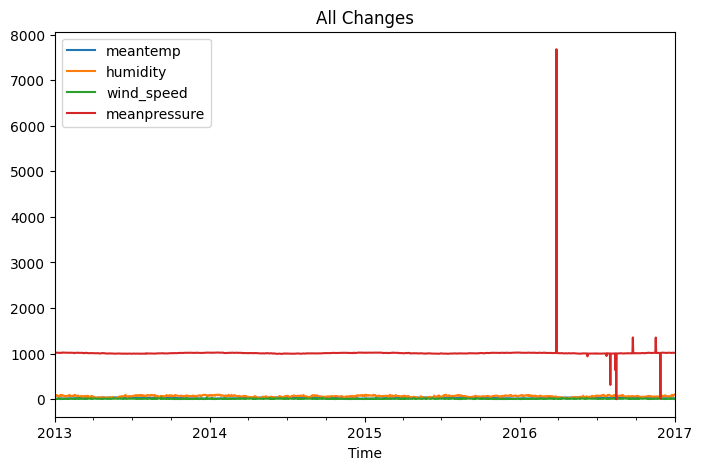

In [23]:
df_train.plot(figsize = (8, 5))
plt.xlabel('Time')
plt.title('All Changes')
plt.show


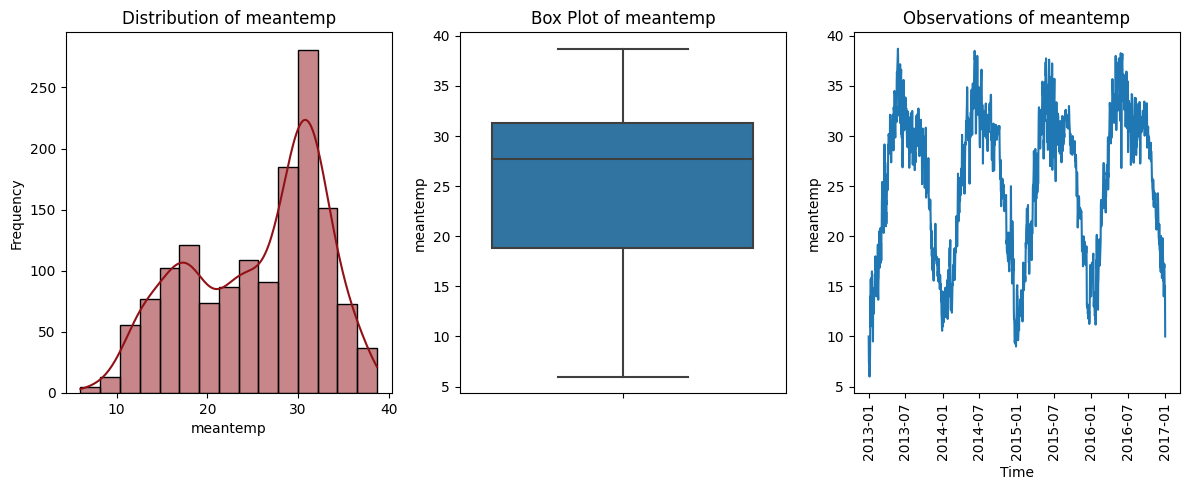

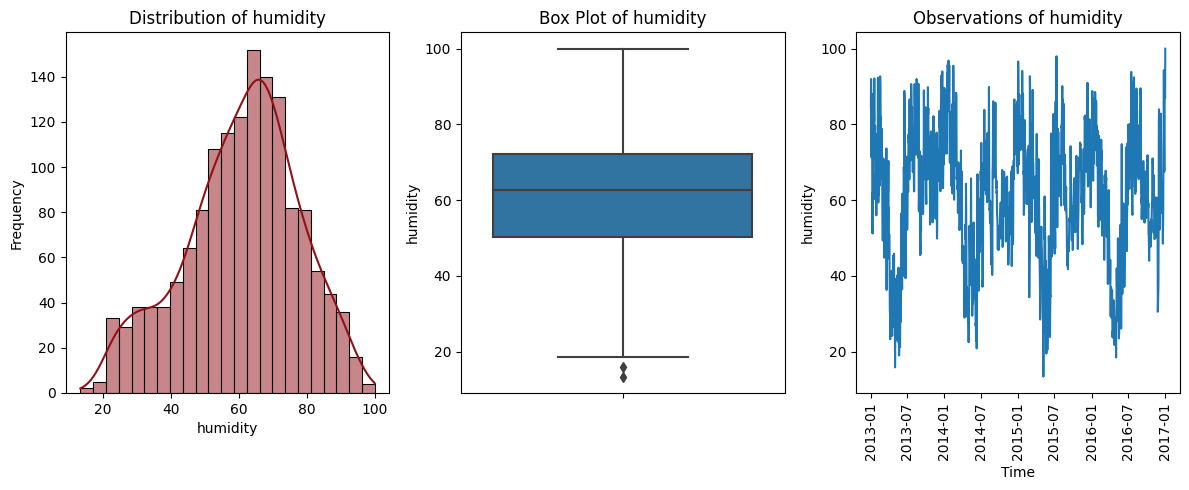

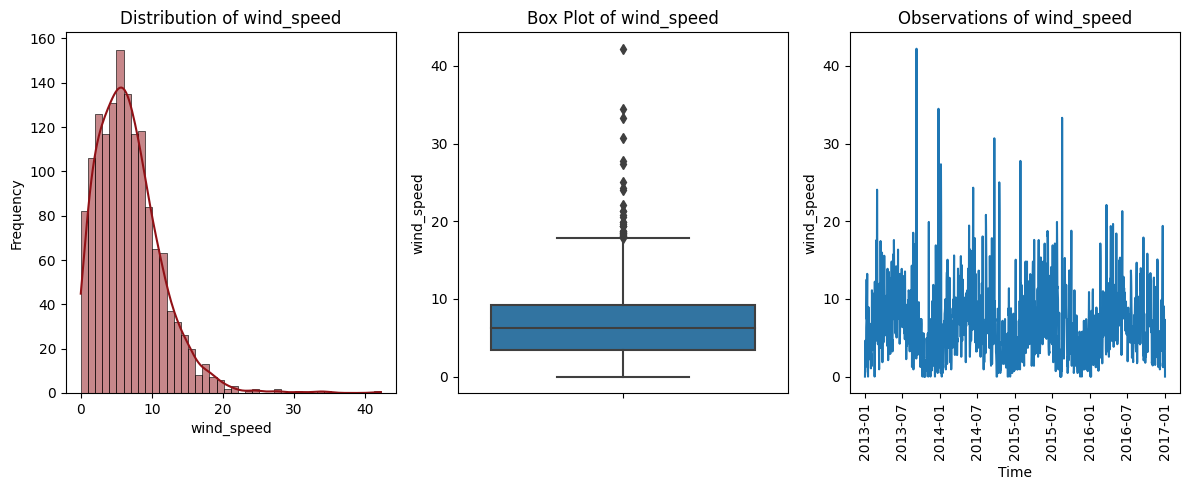

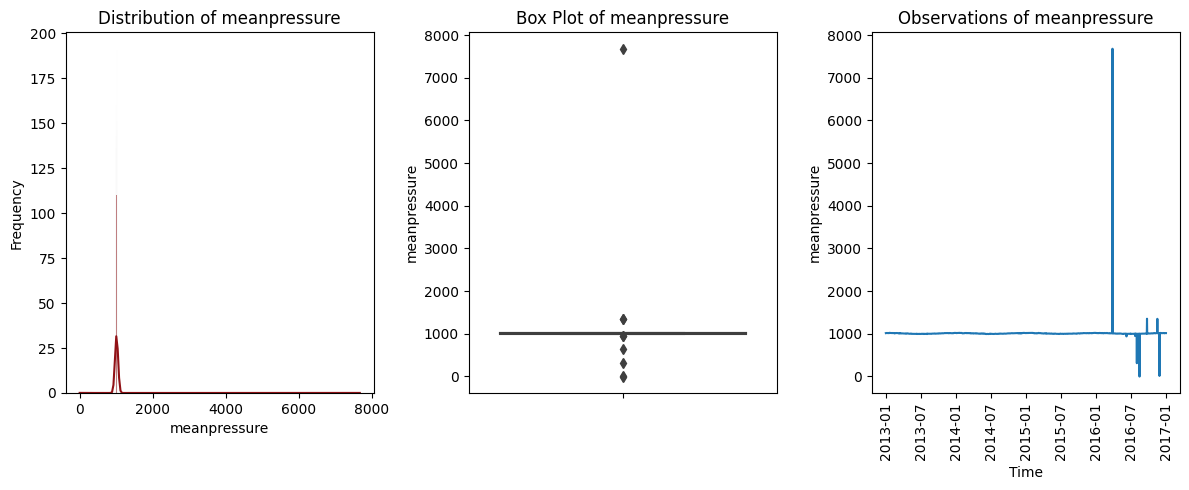

In [24]:
col_names = df_train.columns
for col in col_names:
     plt.figure(figsize=(12, 5))
     # Defining subplots in one row and two columns
     # In index one of the subplot, we will have histogram
     plt.subplot(1, 3, 1)
     sns.histplot(data=df_train, x=col, kde=True, color = '#911116', line_kws={'color': '#911156'})
     plt.xlabel(col)
     plt.ylabel('Frequency')
     plt.title(f'Distribution of {col}')
     # The second index subplot will have boxplots
     plt.subplot(1, 3, 2)
     sns.boxplot(data=df_train, y=col)
     plt.ylabel(col)
     plt.title(f'Box Plot of {col}')
     # The third plot will display the observations
     plt.subplot(1,3,3)
     sns.lineplot(data=df_train, x=df_train.index, y=col)
     plt.xlabel('Time')
     plt.ylabel(col)
     plt.title(f'Observations of {col}')
     plt.xticks(rotation=90)
     # To make sure that no overlapping 
     plt.tight_layout()
     plt.show()

Lets observe the monthly distributions

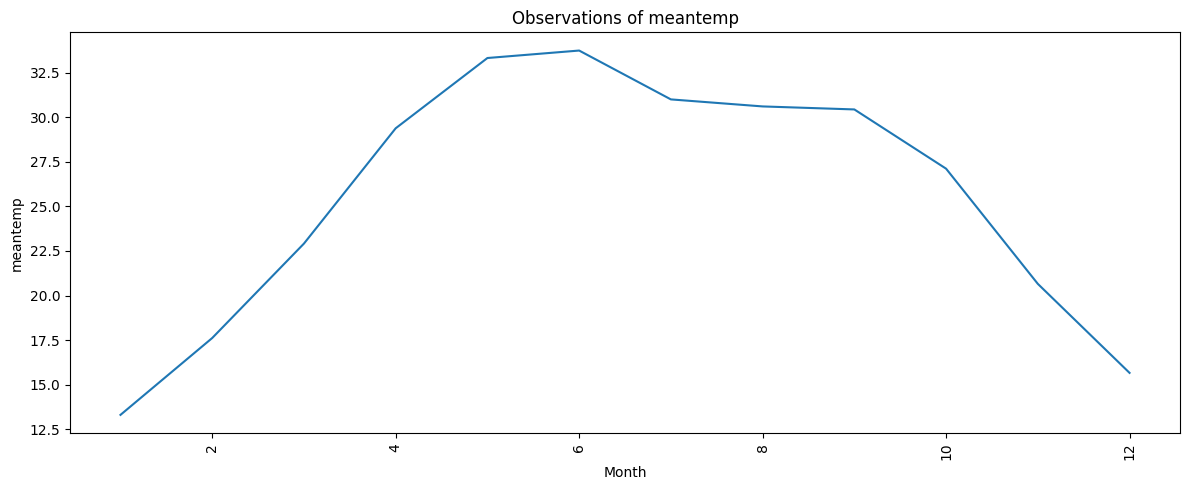

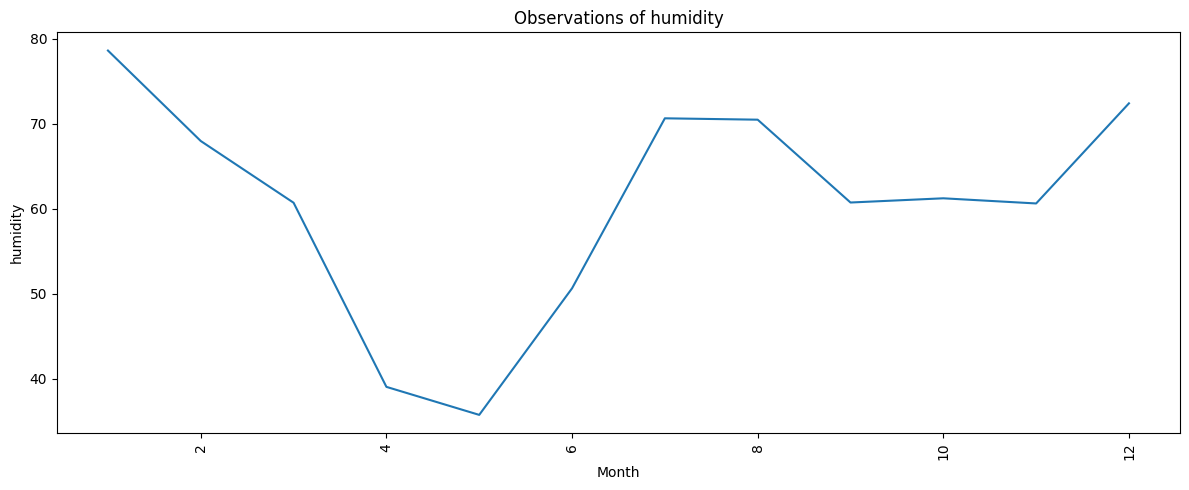

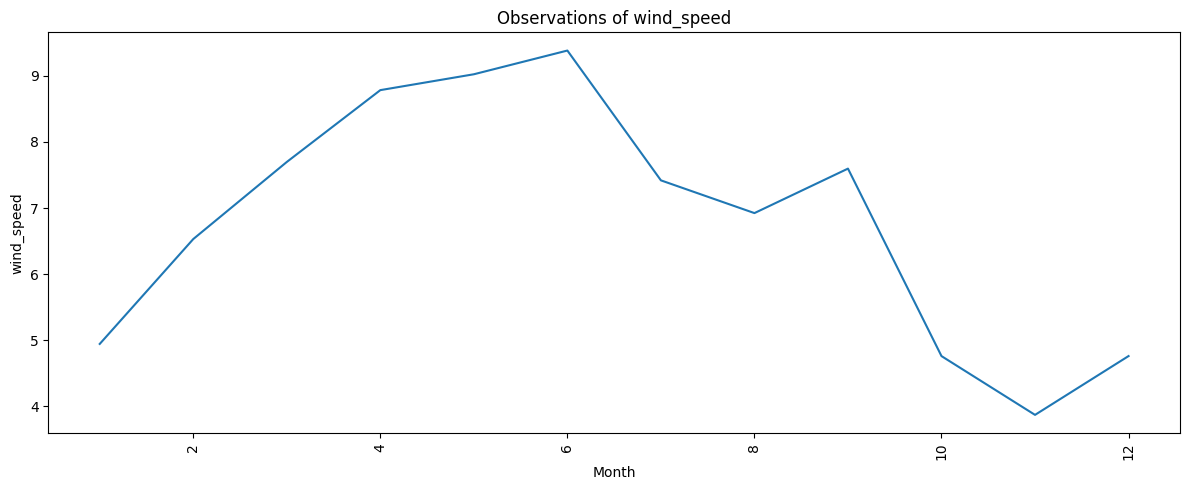

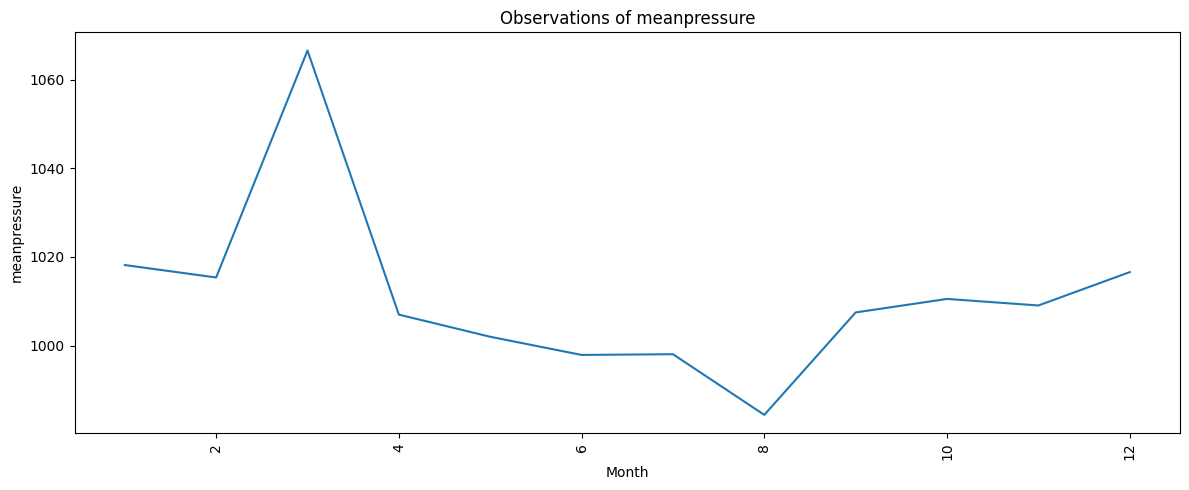

In [25]:
monthly = df_train.groupby(df_train.index.month).mean()
monthly_col = monthly.columns
for col in monthly_col:
    plt.figure(figsize=(12,5))
    sns.lineplot(data=monthly, x=monthly.index, y=col)
    plt.xlabel('Month')
    plt.ylabel(col)
    plt.title(f'Observations of {col}')
    plt.xticks(rotation=90)
    # To make sure that no overlapping 
    plt.tight_layout()
    plt.show()




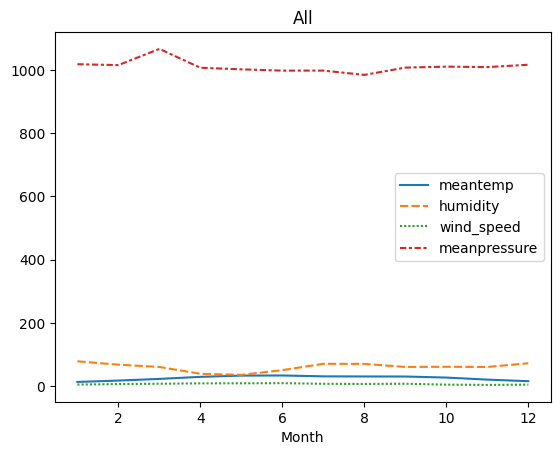

In [26]:
sns.lineplot(monthly)
plt.xlabel('Month')
plt.title('All')
plt.show()

The seasonality here is quite clear.

Lets now decompose this data set into trend, seasonality and noise.

<Figure size 1000x800 with 0 Axes>

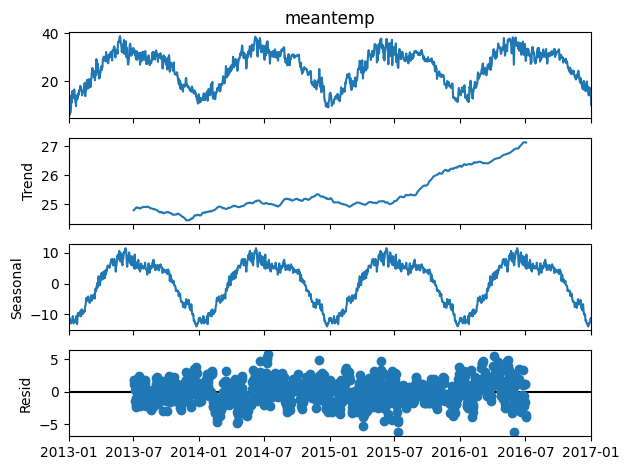

<Figure size 1000x800 with 0 Axes>

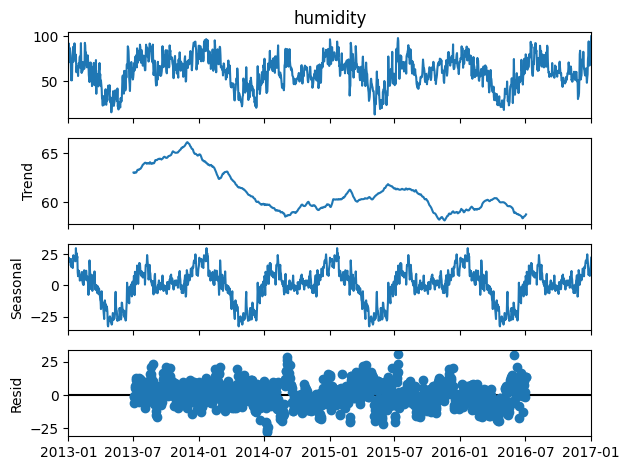

<Figure size 1000x800 with 0 Axes>

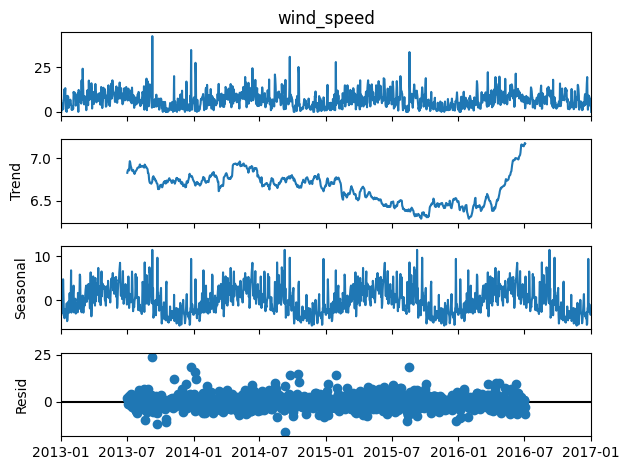

<Figure size 1000x800 with 0 Axes>

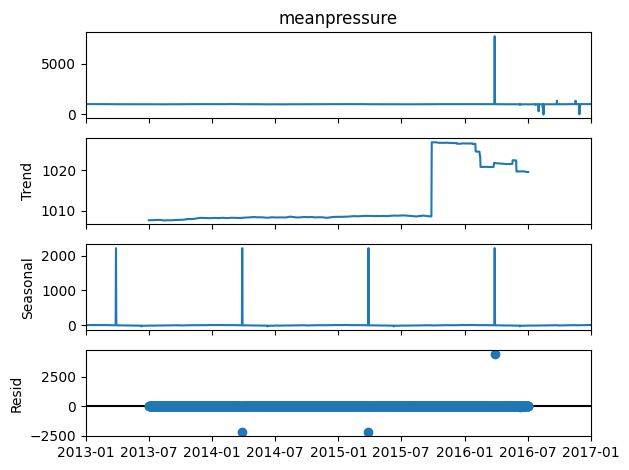

In [27]:
for col in col_names:
    plt.figure(figsize=(10,8))
    decomposition = seasonal_decompose(df_train[col], period=365)
    decomposition.plot()
    plt.show()

We see a strong seasonality in Meantemp, Humidity, Windspeed, and a weak seasonality in Meanpressure.

Also, Meantemp has an upward trend over the year. 

Now we will see the the ACF and PACF plots 

Remember the frequency of our train data is set to daily.

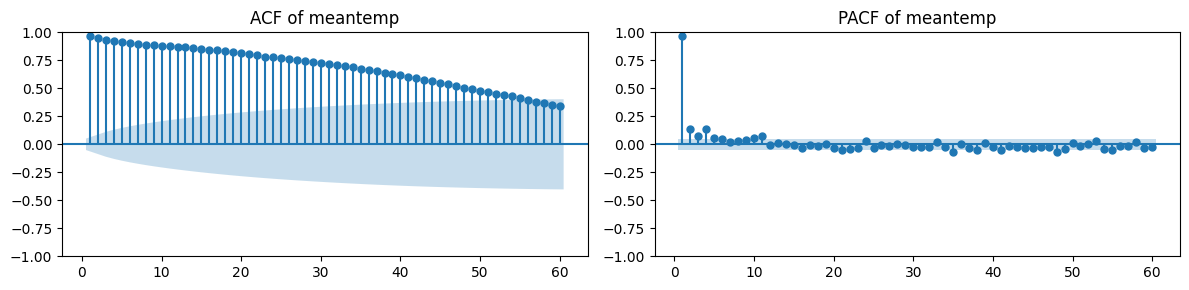

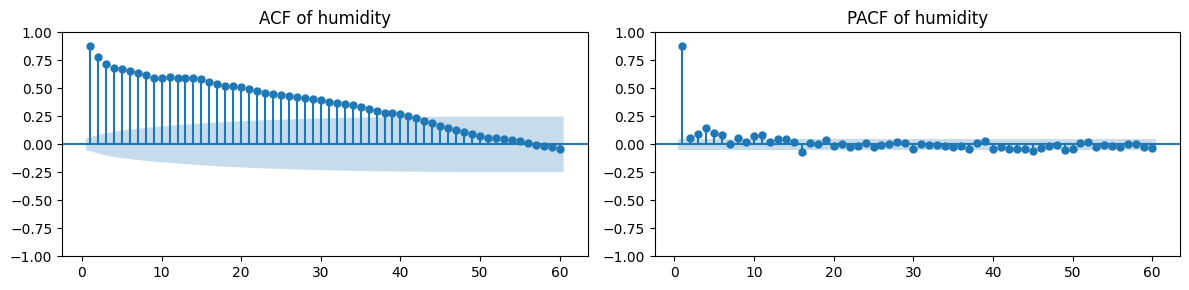

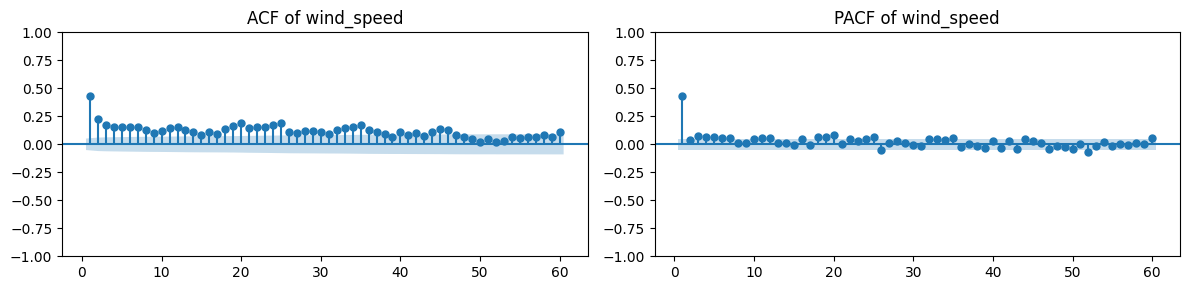

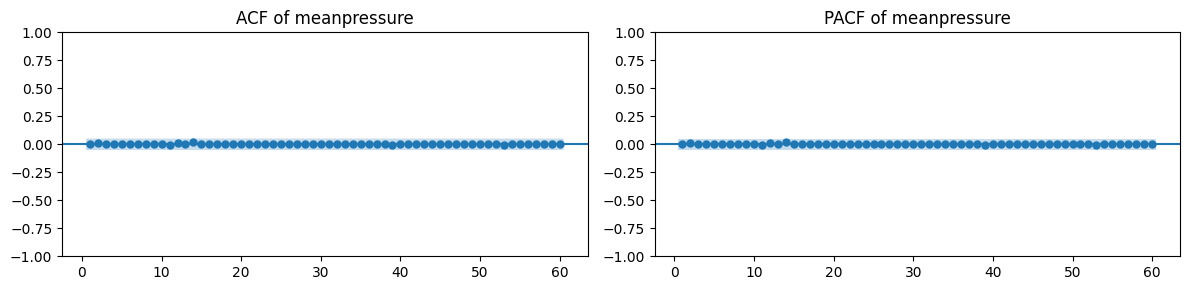

In [28]:
for col in col_names:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
    
    # The first index subplot will have ACF
    plot_acf(df_train[col], lags=60, zero=False, ax=ax1)
    ax1.set_title(f'ACF of {col}')
    
    # The second index subplot will have PACF
    plot_pacf(df_train[col], lags=60, zero=False, ax=ax2)
    ax2.set_title(f'PACF of {col}')
    
    # To make sure that no overlapping 
    plt.tight_layout()
    plt.show()

Lets now observe the Argumented Dicke-Fuller test and see the p-values.

In [29]:
for col in col_names:
    print('The p-value for ' + col + ' is: ' + str(adfuller(df_train[col])[1]))


The p-value for meantemp is: 0.27741213723016167
The p-value for humidity is: 0.0044701004781308035
The p-value for wind_speed is: 0.0025407221531464617
The p-value for meanpressure is: 0.0


Meantemp is non-stationary

In [30]:
meantemp_diff = df_train['meantemp'].diff()
print('The p-value for  meantemp_diff is: ' + str(adfuller(meantemp_diff.dropna())[1]))


The p-value for  meantemp_diff is: 2.764863137594645e-29


The meantemp is stationary after one differencing, now let us detrend the seasonal trend.

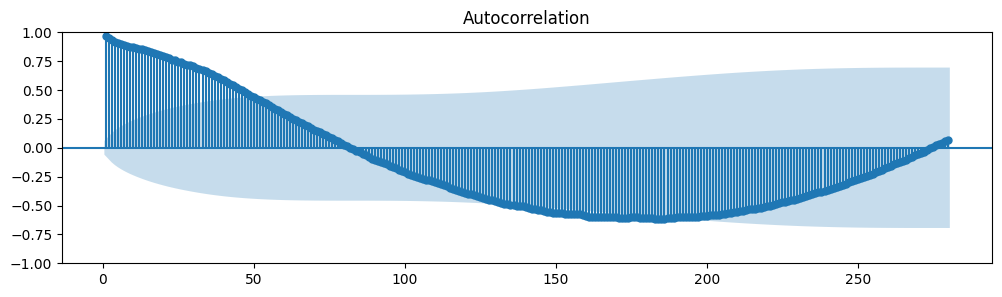

In [31]:
meantemp_sdiff = df_train['meantemp'] - df_train['meantemp'].rolling(370).mean()
fig, ax = plt.subplots(figsize=(12, 3))
plot_acf(meantemp_sdiff.dropna(), lags=280, zero = False, ax = ax)
plt.show()

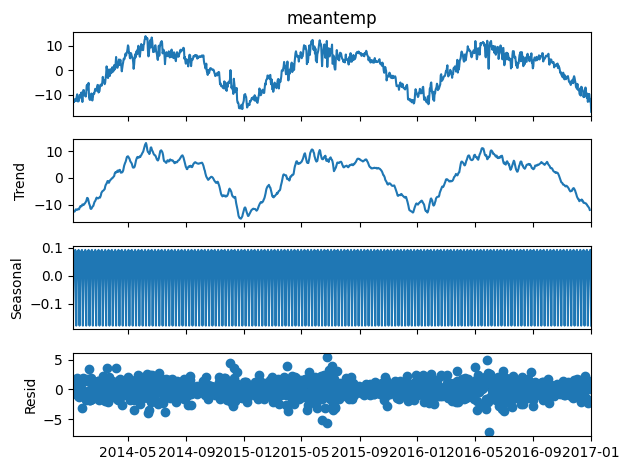

In [32]:
decomp = seasonal_decompose(meantemp_sdiff.dropna())
decomp.plot()
plt.show()

You can see that the seasonal and non-seasonal trends are now detrended, all by the first difference order.

Lets now fit a model, with exogenous variables.

In [33]:
df_train.columns


Index(['meantemp', 'humidity', 'wind_speed', 'meanpressure'], dtype='object')

In [34]:
# Extract the target variable and exogenous variables
y = df_train['meantemp']
X = df_train[['humidity', 'wind_speed', 'meanpressure']]  # Pass exogenous variables as a DataFrame

# Fit the ARIMA model with exogenous variables
results = pm.auto_arima(y, exogenous=X, d=1, D=1, seasonal=True, m=365, trend='c',
                        stepwise=True, suppress_warnings=True, error_action='ignore', start_p=1, start_P=1,max_p=6, max_q=5, start_q=1, start_Q=1, max_Q=3, max_P=3, )


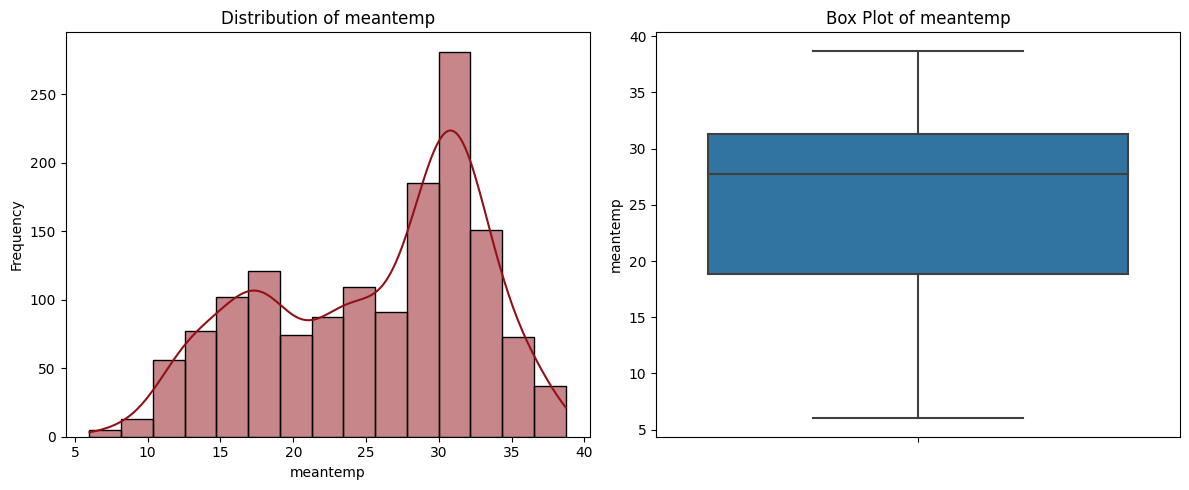

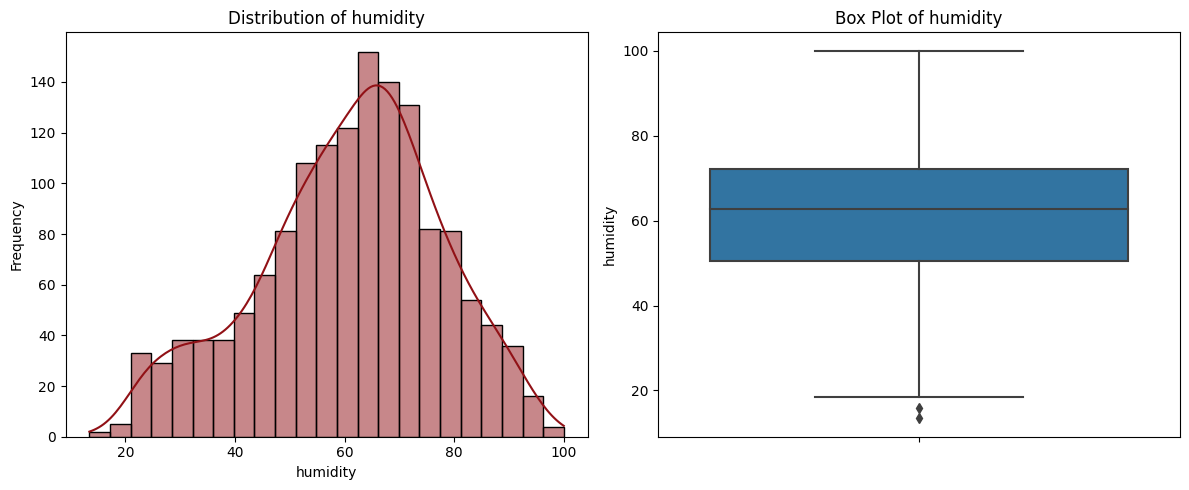

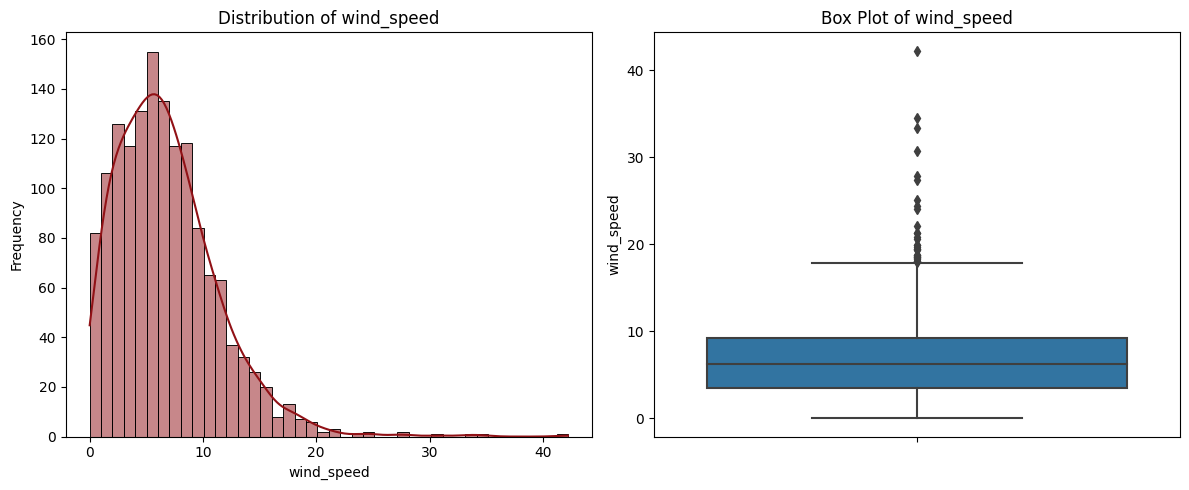

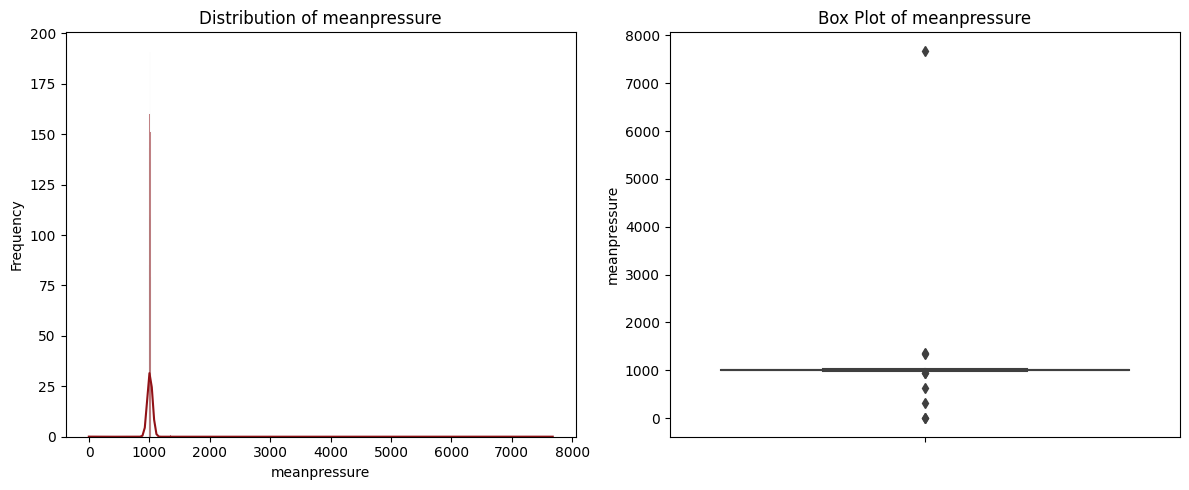

In [ ]:
col_names = df_train.columns
for col in col_names:
     plt.figure(figsize=(12, 5))
     # Defining subplots in one row and two columns
     # In index one of the subplot, we will have histogram
     plt.subplot(1, 2, 1)
     sns.histplot(data=df_train, x=col, kde=True, color = '#911116', line_kws={'color': '#911156'})
     plt.xlabel(col)
     plt.ylabel('Frequency')
     plt.title(f'Distribution of {col}')
     # The second index subplot will have boxplots
     plt.subplot(1, 2, 2)
     sns.boxplot(data=df_train, y=col)
     plt.ylabel(col)
     plt.title(f'Box Plot of {col}')
     # To make sure that no overlapping 
     plt.tight_layout()
     plt.show()